# Logistic regression model
Goal is to make a model that can predict when spot 02 will be available

1st model, assume each time point is independent



## 0 imports

In [1]:

import os
os.chdir('..')
os.getcwd()

'/home/denny/Documents/mids/ev_charging'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data_preprocessing import datetime_processing, userinput_processing, holiday_processing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score


## 1 Data and Cleaning

In [3]:
# load data

In [4]:
df_of = pd.read_parquet('data/ACN-API/office001/').reset_index(drop=True)
df_of = datetime_processing(df_of)
df_of = userinput_processing(df_of)
df_of = holiday_processing(df_of)


In [5]:
df_of.head()

,_id,userID,sessionID,stationID,spaceID,siteID,clusterID,connectionTime,disconnectTime,kWhDelivered,...,doneChargingTimeDay,userID,milesRequested,WhPerMile,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,kWhRequested,is_holiday
0,5cd1d47af9af8b68f0e96713,None,19_102_260_1633_2019-03-25 16:24:42.408146,19-102-260-1633,02,19,102,2019-03-25 16:24:42+00:00,2019-03-26 01:32:12+00:00,6.146,...,25.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
1,5cd1d47af9af8b68f0e96714,None,19_102_260_1634_2019-03-25 17:19:26.896309,19-102-260-1634,03,19,102,2019-03-25 17:19:27+00:00,2019-03-26 00:38:50+00:00,3.658,...,25.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
2,5cd1d47af9af8b68f0e96715,None,19_102_260_1640_2019-03-25 21:27:32.338192,19-102-260-1640,08,19,102,2019-03-25 21:27:32+00:00,2019-03-26 03:32:03+00:00,28.330,...,26.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
3,5cd1d47df9af8b68f0e96716,None,19_102_260_1640_2019-03-26 18:33:56.204855,19-102-260-1640,08,19,102,2019-03-26 18:33:56+00:00,2019-03-27 00:45:33+00:00,12.978,...,26.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
4,5cd1d47ef9af8b68f0e96717,None,19_102_260_1640_2019-03-27 18:28:00.642220,19-102-260-1640,08,19,102,2019-03-27 18:28:01+00:00,2019-03-28 00:37:47+00:00,10.688,...,27.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False


In [6]:
df_of.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681 entries, 0 to 1680
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   _id                   1681 non-null   object             
 1   userID                583 non-null    object             
 2   sessionID             1681 non-null   object             
 3   stationID             1681 non-null   object             
 4   spaceID               1681 non-null   object             
 5   siteID                1681 non-null   int64              
 6   clusterID             1681 non-null   int64              
 7   connectionTime        1681 non-null   datetime64[ns, UTC]
 8   disconnectTime        1681 non-null   datetime64[ns, UTC]
 9   kWhDelivered          1681 non-null   float64            
 10  doneChargingTime      1627 non-null   datetime64[ns, UTC]
 11  connectionTimeHour    1681 non-null   int32              
 12  connec

## 2 plotting and eval

In [7]:
def make_classification_plot(cm):
    disp = ConfusionMatrixDisplay(cm)
    disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.grid(False)
    plt.show()

In [8]:
def get_results(y_test, prediction):
    cm = confusion_matrix(y_test,prediction)
    make_classification_plot(cm)
    
    results = {'tpr': cm[1, 1]/np.sum(cm[1]),
               'fpr': cm[0,1]/np.sum(cm[0]),
               'accuracy': accuracy_score(y_test, prediction),
               'precision': precision_score(y_test, prediction),
               'recall': recall_score(y_test, prediction),
        'f1':f1_score(y_test,prediction)}
    return results
    

In [9]:
results = {}

# 3 Make X and y values

In [10]:
tmp = df_of.copy().set_index('connectionTime')
tmp = tmp[tmp['spaceID'] == '02'].sort_index()

In [118]:
# TODO: make better variable names ie start_ -> session_start_time
y = pd.DataFrame(index=pd.date_range('2019-03-25','2021-09-12', inclusive='both', freq='h', tz=0),columns=['is_available','sessionID'])
y['is_available'] = 1
for i in range(len(tmp)):
    start_ = tmp.index[i]
    end_ = tmp.loc[start_,'disconnectTime'] 
    session_ = tmp.loc[start_,'sessionID']
    # print(start_,'\t', end_,'\t', session_)
    y.loc[start_:end_,['is_available','sessionID']] = 0, session_

In [119]:
y = y['is_available']

In [120]:
X = pd.DataFrame(index=pd.date_range('2019-03-25','2021-09-12', inclusive='both', freq='h', tz=0),columns=['dow','hour','month'])
# X['dow'] = X.index.dt.hour
X['dow'] = X.index.dayofweek
X['hour'] = X.index.hour
X['month'] = X.index.month
X['connectionTime'] = X.index
X = holiday_processing(X).drop(columns=['connectionTime'])
X.head()

,dow,hour,month,is_holiday
2019-03-25 00:00:00+00:00,0,0,3,False
2019-03-25 01:00:00+00:00,0,1,3,False
2019-03-25 02:00:00+00:00,0,2,3,False
2019-03-25 03:00:00+00:00,0,3,3,False
2019-03-25 04:00:00+00:00,0,4,3,False


In [121]:
# print(f'charger spot #2 is available {np.round(y.is_available.mean()*100,3)}% of the time')
print(f'charger spot #2 is available {np.round(y.mean()*100,3)}% of the time')

charger spot #2 is available 89.297% of the time


In [122]:
X.shape[0] == y.shape[0]

True

# 4 model time

## using a stratified train test split as often as possible
https://www.investopedia.com/terms/stratified_random_sampling.asp

In [123]:
# Create hold out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify=y)
print(f'the training data has an average availability of {np.round(y_train.mean()*100,3)}%')


the training data has an average availability of 89.295%


## 4.1 Baselines

### 4.10 Guess always available (baseline)

guess always available and never available


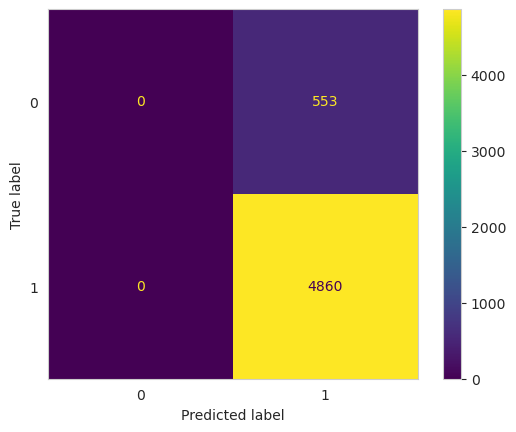

In [67]:
print('guess always available and never available')
results['always_available'] = get_results(y_test, [1] * len(y_test))


### 4.11 Guess never available (baseline)

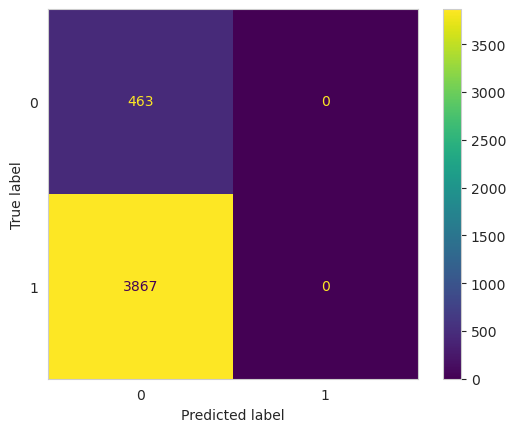

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
print('guess never available') 
results['never_available'] = get_results(y_test, [0] * len(y_test))

## 4.2 Sklearn logistic regression models

## 4.21 L2 penalty

The average accuracy is 0.893 ± 0.000
test accuracy is 0.892147806004619


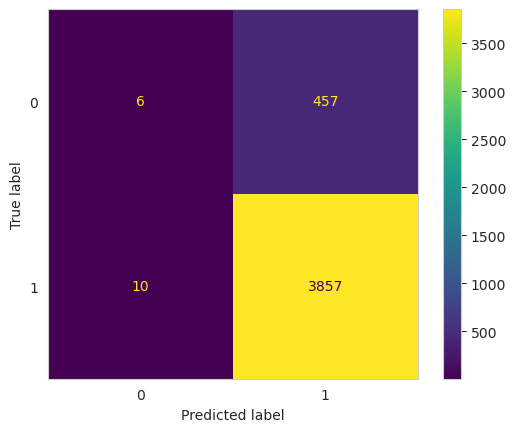

In [151]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


model = LogisticRegression(penalty='l2')
pipe = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')),
    ('lr', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_log_l2_skf'] = get_results(y_test, pred)


In [152]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train, y_train, cv=skf)

array([0.89312316, 0.89225706, 0.8926035 ])

In [153]:
# standard error for 

In [197]:
# https://stackoverflow.com/questions/22381497/python-scikit-learn-linear-model-parameter-standard-error
N = len(X_train)
p = len(pipe[0].get_feature_names_out()) + 1  # plus one because LinearRegression adds an intercept term
print('X shape :', N,p)
X_with_intercept = np.empty(shape=(N, p), dtype='float')
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = pipe[0].transform(X_train)# ohe.transform(X_train)
beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y_train.values
coefs_intercept = np.concatenate((pipe[1].intercept_, pipe[1].coef_.reshape(-1)))
col_names = ['intercept'] + list(pipe[:-1].get_feature_names_out())
pd.DataFrame(data=np.concatenate([[coefs_intercept], [beta_hat]]),
             columns=['intercept'] + list(pipe[:-1].get_feature_names_out())).T.reset_index().rename(columns={0:'estimation',1:'standard_error','index':'coefficient'})

X shape : 17319 41
[ 0.77091223 -0.02626377 -0.03252715 -0.04353771 -0.0400518   0.08978958
  0.11574732  0.06400798  0.10542119  0.16865039  0.1822024   0.18857691
  0.18933088  0.1913663   0.19060434  0.18958701  0.18845189  0.19087266
  0.18880923  0.19030539  0.18960058  0.1310084   0.02612451 -0.07993205
 -0.08351877 -0.07885957 -0.07150381 -0.08554768 -0.06628984 -0.04441961
  0.01537249 -0.01056361  0.03380858  0.05004191  0.04196484  0.0353471
  0.03441016  0.02544022  0.01119876  0.03199691  0.03491432]


,coefficient,estimation,standard_error
0,intercept,1.415216,0.770912
1,dow_1,-0.299681,-0.026264
2,dow_2,-0.368269,-0.032527
3,dow_3,-0.474602,-0.043538
4,dow_4,-0.432020,-0.040052
5,dow_5,1.666958,0.089790
6,dow_6,4.647834,0.115747
7,hour_1,0.162144,0.064008
8,hour_2,0.626664,0.105421
9,hour_3,1.993085,0.168650


In [157]:
# https://stackoverflow.com/questions/22381497/python-scikit-learn-linear-model-parameter-standard-error
X_with_intercept = np.empty(shape=(N, p), dtype='float')
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = pipe[0].transform(X_train)# ohe.transform(X_train)
X_with_intercept
beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y_train.values
print(beta_hat)

[ 0.77091223 -0.02626377 -0.03252715 -0.04353771 -0.0400518   0.08978958
  0.11574732  0.06400798  0.10542119  0.16865039  0.1822024   0.18857691
  0.18933088  0.1913663   0.19060434  0.18958701  0.18845189  0.19087266
  0.18880923  0.19030539  0.18960058  0.1310084   0.02612451 -0.07993205
 -0.08351877 -0.07885957 -0.07150381 -0.08554768 -0.06628984 -0.04441961
  0.01537249 -0.01056361  0.03380858  0.05004191  0.04196484  0.0353471
  0.03441016  0.02544022  0.01119876  0.03199691  0.03491432]


In [193]:
pipe[:-1].get_feature_names_out()
pipe[1].coef_
pd.DataFrame(data=np.concatenate([[coefs_intercept], [beta_hat]]),
             columns=['intercept'] + list(pipe[:-1].get_feature_names_out())).T.reset_index().rename(columns={0:'estimation',1:'standard_error','index':'coefficient'})

,coefficient,estimation,standard_error
0,intercept,1.415216,0.770912
1,dow_1,-0.299681,-0.026264
2,dow_2,-0.368269,-0.032527
3,dow_3,-0.474602,-0.043538
4,dow_4,-0.432020,-0.040052
5,dow_5,1.666958,0.089790
6,dow_6,4.647834,0.115747
7,hour_1,0.162144,0.064008
8,hour_2,0.626664,0.105421
9,hour_3,1.993085,0.168650


## 4.22 L1 penalty

The average accuracy is 0.893 ± 0.000
test accuracy is 0.892147806004619


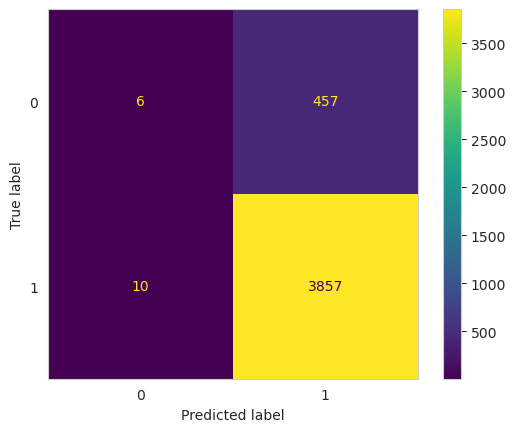

In [199]:
model = LogisticRegression(penalty='l1', solver='liblinear')
pipe = Pipeline([
    ('ohe', OneHotEncoder()),
    ('lrl1', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_log_reg_l1_skf'] = get_results(y_test, pred)


In [200]:
print(pipe[-1].coef_.shape)
pipe[-1].n_features_in_
pipe[-1].intercept_
pipe[-1].classes_
pd.DataFrame(pipe[-1].coef_, columns=pipe[:-1].get_feature_names_out()).T
# ?pipe[-1]
# pipe[:-1].get_feature_names_out()

(1, 44)


,0
dow_0,0.346873
dow_1,0.061493
dow_2,0.000000
dow_3,-0.104910
dow_4,-0.064220
dow_5,2.048134
dow_6,6.308125
hour_0,-1.351276
hour_1,-0.843349
hour_2,-0.370393


In [28]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
# A sample toy binary classification dataset
# X, y = datasets.make_classification(n_classes=2, random_state=0)
# svm = LinearSVC(dual="auto", random_state=0)
lr = LogisticRegression(penalty="l2")
def confusion_matrix_scorer(clf, X, y):
     y_pred = clf.predict(X)
     cm = confusion_matrix(y, y_pred)
     return {'tn': cm[0, 0], 'fp': cm[0, 1],
             'fn': cm[1, 0], 'tp': cm[1, 1]}
cv_results = cross_validate(lr, X_train, y_train, cv=5,
                            scoring=confusion_matrix_scorer)
# Getting the test set true positive scores
print(cv_results['test_tp'])
# Getting the test set false negative scores
print(cv_results['test_fn'])

[3093 3093 3093 3093 3093]
[0 0 0 0 0]


## 4.23 elastic net penalty

# TO DO: use gridsearch to find best l1 ratio

The average accuracy is 0.891 ± 0.000
test accuracy is 0.8978385368557177


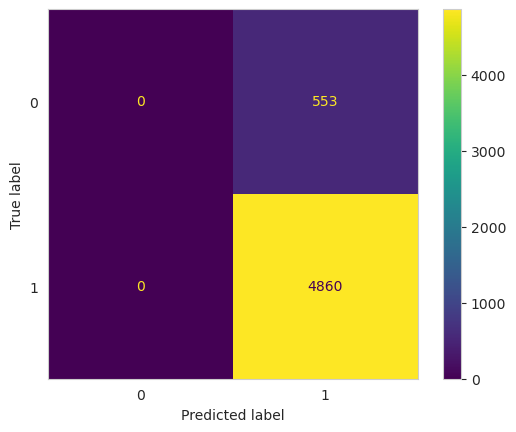

In [77]:
model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.1)
pipe = Pipeline([
    ('ohe', OneHotEncoder()),
    ('lrl1', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_log_elasticnet_skf'] = get_results(y_test, pred)

## 4.3 Sklearn Random Forrest Classifier

The average accuracy is 0.865 ± 0.003
test accuracy is 0.8732101616628175


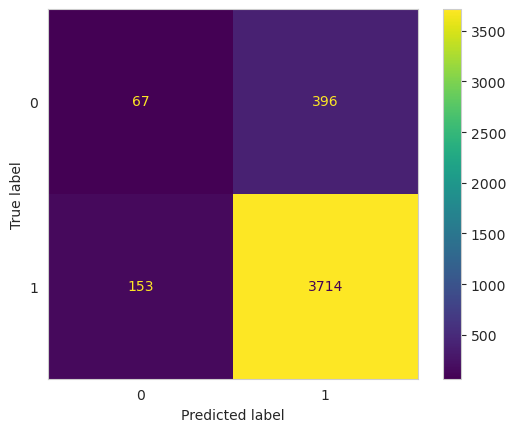

In [29]:
# tree models
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
pipe = Pipeline([
    ('ohe', OneHotEncoder()),
    ('rf', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_rf_classification_skf'] = get_results(y_test, pred)


# 4.4 stats model version

In [30]:
! pip install statsmodels

In [31]:
import statsmodels.api as sm 
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['dow']])
ohe.transform(X[['dow']])
pd.DataFrame(ohe.transform(X[['dow']]), columns=ohe.get_feature_names_out(), index=X.index)

,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
2019-03-25 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-09-11 20:00:00+00:00,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-11 21:00:00+00:00,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-11 22:00:00+00:00,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-11 23:00:00+00:00,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['dow']])
ohe.transform(X[['dow']])
ohe.get_feature_names_out()
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['dow']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
log_reg = sm.Logit(y_train, X_train).fit() 

         Current function value: 0.360711
         Iterations: 35


/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [201]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(X[['dow']])
ohe.transform(X[['dow']])
ohe.get_feature_names_out()
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['dow']]), columns=ohe.get_feature_names_out(), index=X.index),#.drop(columns=ohe.get_feature_names_out()[0:3]), 
    y, 
    test_size=.2, 
    stratify=y)
log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())

         Current function value: 0.312205
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17312
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                 0.08257
Time:                        16:38:16   Log-Likelihood:                -5407.1
converged:                      False   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                5.422e-207
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_0          2.0099      0.062     32.252      0.000       1.888       2.132
dow_1          1.8172      0.058     31.487      0.000       1.70

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
print(log_reg.summary()) 

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17315
Method:                           MLE   Df Model:                            3
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                 -0.2942
Time:                        13:23:49   Log-Likelihood:                -7627.9
converged:                      False   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_3          1.6677      0.055     30.208      0.000       1.560       1.776
dow_4          1.6976      0.056     30.584      0.000       1.589       1.806
dow_5          3.5666      0.123     29.004      0.0

In [35]:
y_hat = log_reg.predict(X_test)
prediction = list(map(round, y_hat))
# confusion matrix 
cm = confusion_matrix(y_test, prediction)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[ 253  210]
 [1573 2294]]
Test accuracy =  0.5882217090069284


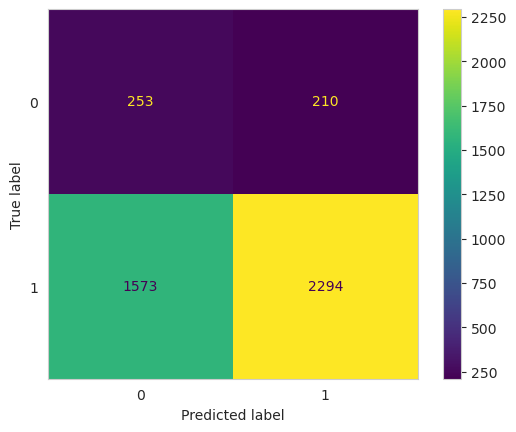

In [36]:
results['sm_log_reg_dow_skf'] = get_results(y_test, prediction)

In [37]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['hour']])
ohe.transform(X[['hour']])
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), y['is_available'])
log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.270214
         Iterations 10


In [38]:
print(log_reg.summary()) 

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17296
Method:                           MLE   Df Model:                           22
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                  0.2060
Time:                        13:23:49   Log-Likelihood:                -4679.8
converged:                       True   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour_1         1.7620      0.104     16.916      0.000       1.558       1.966
hour_2         2.4744      0.139     17.783      0.000       2.202       2.747
hour_3         3.7349      0.245     15.219      0.0

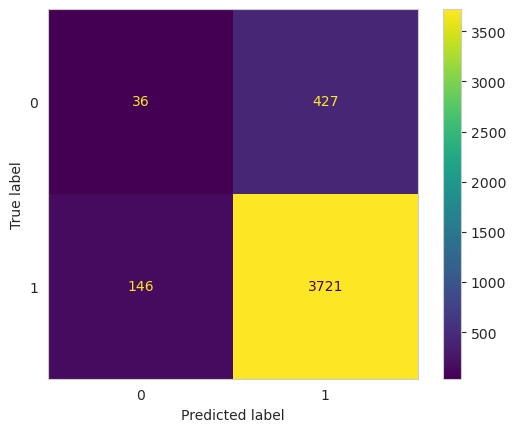

In [39]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
results['sm_hour_sfk'] = get_results(y_test, prediction)

In [40]:
X_train

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
2020-08-16 03:00:00+00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-26 05:00:00+00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-30 11:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-25 04:00:00+00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-29 23:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-11 08:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-17 03:00:00+00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-13 16:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-09 18:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# not weekend, the log odds is 1.782
# for the weekend, the log odds increases 2.3780, to 4.1606
y_train[X_train.hour_18==True]
# probability of ytrain
print('for not 6 PM...')
p_success = y_train[X_train.hour_18==False].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
p_not6pm = p_success
print('\n\nfor 6 PM,')
p_success = y_train[X_train.hour_18==True].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
print(f'\n\nthe probaility of availability changes from {p_success} to {p_not6pm}, a difference of {np.round((p_success-p_not6pm)/p_not6pm*100,3)}%')

for not 6 PM...
prob of success 0.8997890931003314
prob of failure 0.1002109068996686
odds of success 8.978953698135896
log odds of success 2.1948833608415463


for 6 PM,
prob of success 0.7361878453038674
prob of failure 0.2638121546961326
odds of success 2.7905759162303663
log odds of success 1.0262479961192146


the probaility of availability changes from 0.7361878453038674 to 0.8997890931003314, a difference of -18.182%


In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.20      0.08      0.11       463
           1       0.90      0.96      0.93      3867

    accuracy                           0.87      4330
   macro avg       0.55      0.52      0.52      4330
weighted avg       0.82      0.87      0.84      4330


In [43]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['month','hour']])
ohe.transform(X[['month','hour']])
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['month','hour']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), y['is_available'])
log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.262322
         Iterations 11


In [44]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17285
Method:                           MLE   Df Model:                           33
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                  0.2292
Time:                        13:23:49   Log-Likelihood:                -4543.2
converged:                       True   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_2        0.7838      0.119      6.572      0.000       0.550       1.018
month_3        0.3518      0.103      3.413      0.001       0.150       0.554
month_4        0.9065      0.102      8.916      0.0

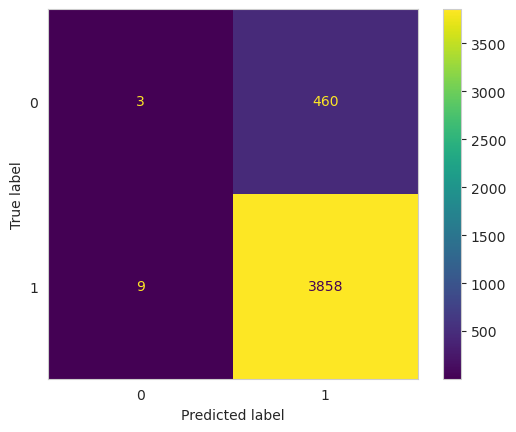

In [45]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
results['sm_month_hour_skf'] = get_results(y_test, prediction)


In [46]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X)
ohe.transform(X)
ohe.get_feature_names_out()[0]

X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X), columns=ohe.get_feature_names_out(), index=X.index), #.drop(columns=ohe.get_feature_names_out()[0]), 
    y, 
    test_size=.2, 
    stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), y['is_available'])
log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())

         Current function value: 0.228411
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17279
Method:                           MLE   Df Model:                           39
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                  0.3288
Time:                        13:23:50   Log-Likelihood:                -3955.8
converged:                      False   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_1         -0.0551      0.088     -0.626      0.531      -0.227       0.117
dow_2         -0.2004      0.087     -2.308      0.021      -0.37

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


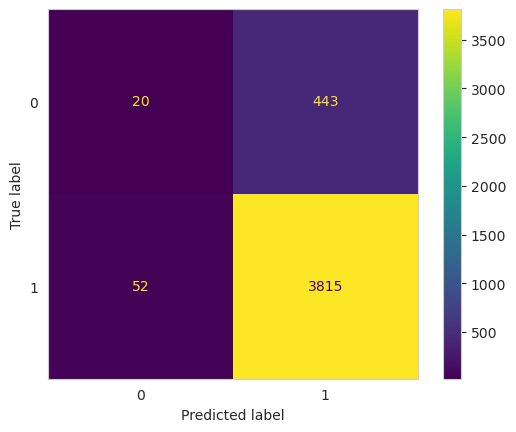

In [47]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
results['sm_month_hour_dow_skf'] = get_results(y_test, prediction)

guess always available and never available


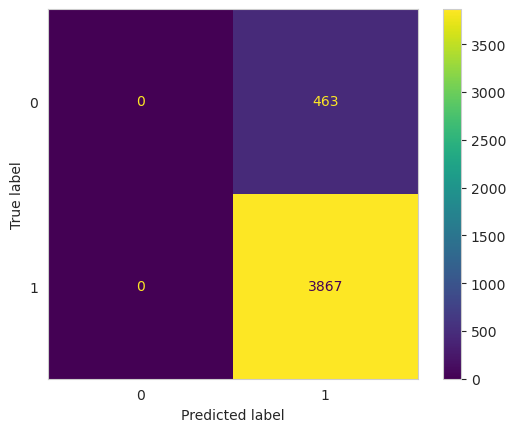

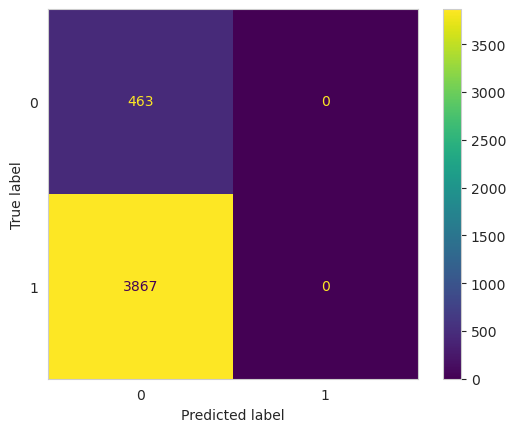

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
print('guess always available and never available')
results['always_available'] =  get_results(y_test, [1]*len(y_test))
results['never_available'] =  get_results(y_test, [0]*len(y_test))


In [49]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['month']])
ohe.transform(X[['month']])
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['month']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.358929
         Iterations 6


In [50]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17308
Method:                           MLE   Df Model:                           10
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                -0.05473
Time:                        13:23:50   Log-Likelihood:                -6216.3
converged:                       True   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_2        2.0866      0.096     21.649      0.000       1.898       2.276
month_3        1.7882      0.079     22.694      0.000       1.634       1.943
month_4        2.1736      0.080     27.323      0.0

In [51]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
yhat

2019-05-24 19:00:00+00:00    0.915872
2019-09-24 18:00:00+00:00    0.897944
2020-03-04 00:00:00+00:00    0.856707
2021-03-16 14:00:00+00:00    0.856707
2019-09-24 14:00:00+00:00    0.897944
                               ...   
2020-09-03 12:00:00+00:00    0.897944
2020-08-28 20:00:00+00:00    0.895938
2020-11-01 18:00:00+00:00    0.902289
2021-07-09 19:00:00+00:00    0.898381
2019-11-05 21:00:00+00:00    0.902289
Length: 4330, dtype: float64

In [52]:
print(classification_report(y_test, prediction))
confusion_matrix(y_test, prediction)


              precision    recall  f1-score   support

           0       0.12      0.08      0.09       463
           1       0.89      0.93      0.91      3867

    accuracy                           0.84      4330
   macro avg       0.51      0.50      0.50      4330
weighted avg       0.81      0.84      0.82      4330


array([[  36,  427],
       [ 265, 3602]])

In [53]:
from sklearn.metrics import  f1_score, precision_score, recall_score
print(f'Precision: out of all the times the model predicted the charger would be available, {np.round(precision_score(y_test, prediction)*100,3)}% of the time it actually was available')
print(f'Recall: out of all the times the charger was available, the model predicted the outcome correctly for {np.round(recall_score(y_test, prediction)*100,3)}% of those times')
print(f'F1 score: the precision recall balance of the model was {np.round(f1_score(y_test,prediction),3)}')
print(f'support available:   {np.sum(y_test==1)}')
print(f'support unavailable: {np.sum(y_test==0)}')


Precision: out of all the times the model predicted the charger would be available, 89.402% of the time it actually was available
Recall: out of all the times the charger was available, the model predicted the outcome correctly for 93.147% of those times
F1 score: the precision recall balance of the model was 0.912
support available:   3867
support unavailable: 463


In [54]:
pd.DataFrame(results).T

,tpr,fpr,accuracy,precision,recall,f1
always_available,1.000000,1.000000,0.893072,0.893072,1.000000,0.943516
never_available,0.000000,0.000000,0.106928,0.000000,0.000000,0.000000
sk_log_reg_vanila_skf,0.997673,0.978402,0.893303,0.894920,0.997673,0.943507
sk_log_reg_l1_skf,0.997673,0.976242,0.893533,0.895128,0.997673,0.943622
sk_rf_classification_skf,0.960434,0.855292,0.873210,0.903650,0.960434,0.931177
sm_log_reg_dow_skf,0.593225,0.453564,0.588222,0.916134,0.593225,0.720138
sm_hour_sfk,0.962245,0.922246,0.867667,0.897059,0.962245,0.928509
sm_month_hour_skf,0.997673,0.993521,0.891686,0.893469,0.997673,0.942700
sm_month_hour_dow_skf,0.986553,0.956803,0.885681,0.895961,0.986553,0.939077


# Interpreting model coefficients

In [55]:
# probability of ytrain
p_success = y_train.mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')

prob of success 0.892949939372943
prob of failure 0.10705006062705702
odds of success 8.341423948220061
log odds of success 2.121233938993369


In [56]:
dummy_1 = pd.DataFrame([1]*len(y_train), columns=['intercept'], index=y_train.index)
int_model = sm.Logit(y_train, dummy_1).fit()

Optimization terminated successfully.
         Current function value: 0.340303
         Iterations 6


In [57]:
print(int_model.summary())

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17318
Method:                           MLE   Df Model:                            0
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:               3.623e-11
Time:                        13:23:50   Log-Likelihood:                -5893.7
converged:                       True   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1212      0.025     86.309      0.000       2.073       2.169


In [58]:
print(f'the model intercept term is {int_model.params.iloc[0]} which is the same as the log odds of the training set {log_odds}')

the model intercept term is 2.121233938993369 which is the same as the log odds of the training set 2.121233938993369


# new model

In [59]:
X['is_weekend'] = X['dow'].isin([5,6])
X

,dow,hour,month,is_holiday,is_weekend
2019-03-25 00:00:00+00:00,0,0,3,False,False
2019-03-25 01:00:00+00:00,0,1,3,False,False
2019-03-25 02:00:00+00:00,0,2,3,False,False
2019-03-25 03:00:00+00:00,0,3,3,False,False
2019-03-25 04:00:00+00:00,0,4,3,False,False
...,...,...,...,...,...
2021-09-11 20:00:00+00:00,5,20,9,False,True
2021-09-11 21:00:00+00:00,5,21,9,False,True
2021-09-11 22:00:00+00:00,5,22,9,False,True
2021-09-11 23:00:00+00:00,5,23,9,False,True


In [60]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['is_weekend']])
ohe.transform(X[['is_weekend']])
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['is_weekend']]), columns=ohe.get_feature_names_out(), index=X.index), y)
log_reg = sm.Logit(y_train, sm.add_constant(X_train)).fit() 
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.317798
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                16236
Model:                          Logit   Df Residuals:                    16234
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                 0.07530
Time:                        13:23:50   Log-Likelihood:                -5159.8
converged:                       True   LL-Null:                       -5580.0
Covariance Type:            nonrobust   LLR p-value:                8.916e-185
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.7572      0.026     66.968      0.000       1.706       1.809
is_weekend_Tru

$logit(p/1-p) = \beta_0 + \beta_1*is_weekend$

In [61]:
# not weekend, the log odds is 1.782
# for the weekend, the log odds increases 2.3780, to 4.1606
y_train[X_train.is_weekend_True==True]
# probability of ytrain
print('for weekdays...')
p_success = y_train[X_train.is_weekend_True==False].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
p_notweekend=p_success
print('\n\nfor weekends,')
p_success = y_train[X_train.is_weekend_True==True].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
print(f'\n\nthe probaility of availability changes from {p_success} to {p_notweekend}, a difference of {np.round((p_success-p_notweekend)/p_notweekend*100,3)}%')

for weekdays...
prob of success 0.8528598583030932
prob of failure 0.1471401416969068
odds of success 5.796241926012921
log odds of success 1.7572097637552


for weekends,
prob of success 0.9869154869154869
prob of failure 0.013084513084513083
odds of success 75.42622950819673
log odds of success 4.323155085982157


the probaility of availability changes from 0.9869154869154869 to 0.8528598583030932, a difference of 15.718%


In [62]:
?log_reg
lowt = log_reg.params.iloc[0] + log_reg.params.iloc[1]
lowf = log_reg.params.iloc[0]
prwt = np.exp(lowt)/(1+np.exp(lowt))
prwf = np.exp(lowf)/(1+np.exp(lowf))
print(f'probability of weekend availability {prwt}\nprobability of weekday availability {prwf}')

probability of weekend availability 0.9869154869154868
probability of weekday availability 0.8528598583030931


In [63]:
# weekend add 2.4 to the log odds of availability
# p  exp(beta X)/ 1+ exp(beta X)
# the weekend makes spot availability 2.4 times more likely to occur
# the odds of is availability change by exp(2.49) time for c unit increase in x
np.exp(2.493)

12.097514278865066

In [64]:
print(f'the change in log odds of the day being a weekend is {2.493}')
print(f'that means that the change in odds is {np.exp(2.493)}')

the change in log odds of the day being a weekend is 2.493
that means that the change in odds is 12.097514278865066


In [65]:
is_weekend = 0
P_non_weekend = np.exp(1.7667 + 2.4931 * is_weekend)/(1+np.exp(1.7667 + 2.4931 * is_weekend))
is_weekend = 1
P_weekend = np.exp(1.7667 + 2.4931 * is_weekend)/(1+np.exp(1.7667 + 2.4931 * is_weekend))
print(np.round(P_non_weekend,3), np.round(P_weekend, 3))


0.854 0.986


In [66]:
np.exp(5.2057)/(1+np.exp(5.2057))

0.9945447139365461